In [1]:
import sys
import os
import math
import random
import time
import warnings

BASE_DIR = os.path.dirname(
    os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
sys.path.append(BASE_DIR)
warnings.filterwarnings('ignore')

from apex import amp
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
#from thop import profile
#from thop import clever_format
from torch.utils.data import DataLoader
from config import Config
from public.imagenet import models
from public.imagenet.utils import DataPrefetcher, get_logger, AverageMeter, accuracy
from torch.nn import functional as F
import CLR as CLR
import OneCycle as OneCycle

In [2]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

## Find Cyclic Learning Rates

start loading data
finish loading data
creating model '6GF'
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
start training
train: iter:30, top1 acc:31.25, Lr:0.0002566823301574701, loss_total:1.3806923627853394
train: iter:60, top1 acc:61.71875, Lr:0.00658858186150685, loss_total:0.9698103070259094
train: iter:90, top1 acc:53.90625, Lr:0.169117254464482, loss

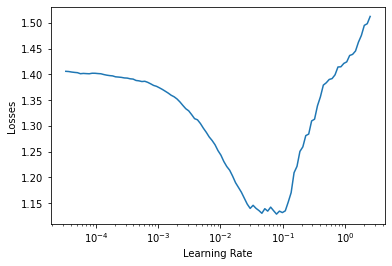

In [3]:
bs=128
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4"
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed_all(0)
cudnn.deterministic = True

gpus = torch.cuda.device_count()

cudnn.benchmark = True
cudnn.enabled = True
start_time = time.time()

# dataset and dataloader
print('start loading data')
train_loader = DataLoader(Config.train_dataset,
                          batch_size=bs,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8)
print('finish loading data')

print(f"creating model '6GF'")
model = models.__dict__['RegNetY_6_4GF'](**{
    "pretrained": True,
    "num_classes": 4,
})

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()   
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-5)
clr = CLR.CLR(optimizer, len(train_loader))

model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
model = nn.DataParallel(model)

print('start training')
#one epoch is enough
top1 = AverageMeter()
losses = AverageMeter()
# switch to train mode
model.train()

iters = len(train_loader.dataset) // bs
prefetcher = DataPrefetcher(train_loader)
inputs, labels = prefetcher.next()
iter_index = 1

i = 0
running_loss = 0.
avg_beta = 0.98

while inputs is not None:
    inputs, labels = inputs.cuda(), labels.cuda()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
    smoothed_loss = running_loss / (1 - avg_beta**(i+1))
    lr = clr.calc_lr(smoothed_loss)
    if lr == -1 :
        break
    update_lr(optimizer, lr)   

    optimizer.zero_grad()        
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()

    optimizer.step()

    # measure accuracy and record loss
    acc1, acc5 = accuracy(outputs, labels, topk=(1, 2))
    top1.update(acc1.item(), inputs.size(0))
    losses.update(loss.item(), inputs.size(0))

    inputs, labels = prefetcher.next()

    if iter_index % 30 == 0:
        print('train: iter:{}, top1 acc:{}, Lr:{}, loss_total:{}'.format(iter_index, acc1.item(), lr, loss.item()))
    iter_index += 1
    i = i + 1

clr.plot()

## Training with One Cycle Policy

In [3]:
bs=64
def train(train_loader, model, criterion, optimizer):
    top1 = AverageMeter()
    losses = AverageMeter()
    # switch to train mode
    model.train()

    iters = len(train_loader.dataset) // bs
    prefetcher = DataPrefetcher(train_loader)
    inputs, labels = prefetcher.next()
    iter_index = 1

    while inputs is not None:
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        lr, mom = onecycle.calc()
        update_lr(optimizer, lr)
        update_mom(optimizer, mom) 

        optimizer.zero_grad()        
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        optimizer.step()

        # measure accuracy and record loss
        acc1, acc5 = accuracy(outputs, labels, topk=(1, 2))
        top1.update(acc1.item(), inputs.size(0))
        losses.update(loss.item(), inputs.size(0))

        inputs, labels = prefetcher.next()

        if iter_index % 100 == 0:
            print('train: iter:{}, top1 acc:{}, Lr:{}, loss_total:{}'.format(iter_index, acc1.item(), lr, loss.item()))
        iter_index += 1
    return top1.avg

In [4]:
def validate(val_loader, model):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    result = 0
    with torch.no_grad():
        end = time.time()
        
        labels_len = 0
        for inputs, labels in val_loader:
            data_time.update(time.time() - end)
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            outputs = F.softmax(outputs, dim=1)
            acc1, acc5 = accuracy(outputs, labels, topk=(1, 2))
            top1.update(acc1.item(), inputs.size(0))
            batch_time.update(time.time() - end)
            end = time.time()
            # compute softmax loss
            pred_score = outputs.cuda().data.cpu().numpy()
            for i in range(len(labels)):
                for j in range(4):
                    if labels[i] == j and pred_score[i][j]>0:
                        result += math.log(pred_score[i][j])
            labels_len += len(labels)
        result = -result/labels_len
        print('rb loss: {}'.format(result))
    throughput = 1.0 / (batch_time.avg / inputs.size(0))
    
    return top1.avg, throughput, result

In [5]:
# dataset and dataloader
train_loader = DataLoader(Config.train_dataset,
                          batch_size=bs,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8)
val_loader = DataLoader(Config.val_dataset,
                            batch_size=bs,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=8)
print('total training image number: {}'.format(len(train_loader.dataset)))


# from cycle learning range test
# I choose Lr:0.00658858186150685
# as requested by paper, I choose one order lower --> 0.00065
epoch=50
onecycle = OneCycle.OneCycle(int(len(train_loader.dataset) * epoch /bs), 0.006588, prcnt=(epoch - 45) * 100/epoch, momentum_vals=(0.95, 0.8))
#onecycle = OneCycle.OneCycle(int(len(train_loader.dataset) * epoch /bs), 3, prcnt=10, momentum_vals=(0.95, 0.8), div=20)

os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4"
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed_all(0)
cudnn.deterministic = True
cudnn.benchmark = True
cudnn.enabled = True
start_time = time.time()



print(f"creating model '6GF'")
model = models.__dict__['RegNetY_6_4GF'](**{
    "pretrained": True,
    "num_classes": 4,
})

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0006588, momentum=0.95, weight_decay=1e-4)

model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
model = nn.DataParallel(model)

print('start training')
min_rb_loss = 1000

train_acc_list = []
valid_acc_list = []
for i in range(0,epoch):
    print('epoch:{}'.format(i))
    train_acc = train(train_loader, model, criterion, optimizer)
    valid_acc, throughput, rb_loss = validate(val_loader, model)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    
    if rb_loss < min_rb_loss:
        min_rb_loss = rb_loss
        print("save model")
        torch.save(
            {
                'epoch': i,
                'acc1': valid_acc,
                'loss': rb_loss,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, os.path.join('./checkpoints_lr', 'latest.pth'))
    

total training image number: 19148
creating model '6GF'
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
start training
epoch:0
train: iter:100, top1 acc:73.4375, Lr:0.0007460070717575397, loss_total:0.8518214225769043
train: iter:200, top1 acc:73.4375, Lr:0.0008340950230277819, loss_total:0.5411978363990784
train: iter:300, top1 acc:58.33333206176758, Lr:0.00

rb loss: 0.13321605441821432
epoch:22
train: iter:100, top1 acc:95.3125, Lr:0.006559811855593523, loss_total:0.11986997723579407
train: iter:200, top1 acc:96.875, Lr:0.0065281001931362355, loss_total:0.09920325875282288
train: iter:300, top1 acc:91.66666412353516, Lr:0.006440012241865993, loss_total:0.21393679082393646
rb loss: 0.13481413859434965
epoch:23
train: iter:100, top1 acc:93.75, Lr:0.006351924290595751, loss_total:0.14048361778259277
train: iter:200, top1 acc:98.4375, Lr:0.006263836339325509, loss_total:0.11186909675598145
train: iter:300, top1 acc:91.66666412353516, Lr:0.006175748388055267, loss_total:0.3411995470523834
rb loss: 0.12399721615959666
save model
epoch:24
train: iter:100, top1 acc:98.4375, Lr:0.006087660436785025, loss_total:0.08170278370380402
train: iter:200, top1 acc:93.75, Lr:0.005999572485514782, loss_total:0.19425806403160095
train: iter:300, top1 acc:83.33332824707031, Lr:0.00591148453424454, loss_total:0.42371776700019836
rb loss: 0.12132727547192847
sav

train: iter:200, top1 acc:96.875, Lr:0.00032728761523046087, loss_total:0.12639287114143372
train: iter:300, top1 acc:75.0, Lr:0.0002876804008016032, loss_total:1.6237406730651855
rb loss: 0.1165694659561373
epoch:48
train: iter:100, top1 acc:89.0625, Lr:0.0002480731863727455, loss_total:0.20606738328933716
train: iter:200, top1 acc:95.3125, Lr:0.00020846597194388775, loss_total:0.13727465271949768
train: iter:300, top1 acc:100.0, Lr:0.00016885875751503006, loss_total:0.011067132465541363
rb loss: 0.11587629024460132
epoch:49
train: iter:100, top1 acc:95.3125, Lr:0.00012925154308617232, loss_total:0.08394692093133926
train: iter:200, top1 acc:96.875, Lr:8.964432865731463e-05, loss_total:0.06511642038822174
train: iter:300, top1 acc:91.66666412353516, Lr:0.0006940351805080969, loss_total:0.11868343502283096
rb loss: 0.12422433444488888


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


65.0616252342146 89.38461538461539


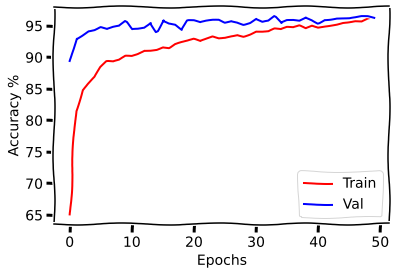

In [7]:
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.xticks(np.arange(0, 100, step=10))
plt.plot(train_acc_list, 'r', label='Train')
plt.plot(valid_acc_list, 'b', label='Val')
plt.legend()
print(train_acc_list[0],valid_acc_list[0])

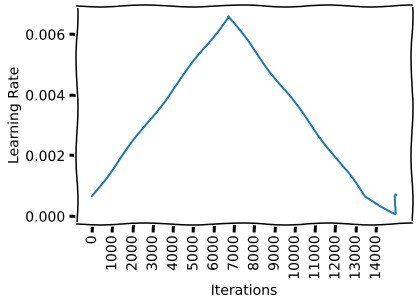

In [8]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=1000), rotation=90)
plt.plot(onecycle.lrs)

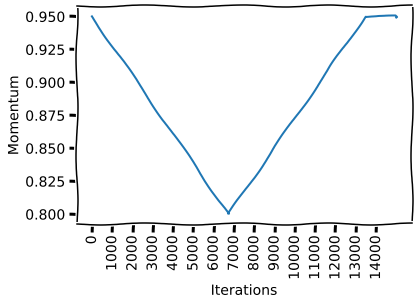

In [9]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Momentum")
plt.xticks(np.arange(0, len(onecycle.moms), step=1000), rotation=90)
plt.plot(onecycle.moms)